In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tangram

from IPython.display import Audio
tada = 'C://Users/stephanies/tada.mp3'

from celltype_mapping import TangramMapping, bin_gene_table, convert_to_anndata

In [3]:
data_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/'

Relevant code for loading raw(ish) data and convering to anndata for use with tangram. Suggest that these data be saved for later loading if they will be reused as they are large and this takes some time. If you've already done this skip down...

In [4]:
sys.path.append('../gene_panel_selection')
sys.path.append('../segmentation')

In [5]:
from segmentation import SpotTable
from gene_panel_selection import ExpressionDataset

In [6]:
bgi_file = data_path + 'NHP_spatial/BGI/macaque-cDNA5.npz'
rnaSeq_data_file = data_path + 'Nik/Analyses_for_great_apes_paper/Shiny_obj_final/rhesus/data.feather'
rnaSeq_anno_file = data_path + 'Nik/Analyses_for_great_apes_paper/Shiny_obj_final/rhesus/anno.feather'

In [35]:
bgi_data = SpotTable.load_stereoseq(cache_file=bgi_file)

Loading from npz..


In [9]:
expression = pd.read_feather(rnaSeq_data_file)
expression.set_index('sample_id', inplace=True)
annotations = pd.read_feather(rnaSeq_anno_file)
annotations.set_index('sample_id', inplace=True)

exp_data = ExpressionDataset(
    expression_data=expression,  
    expression_type='logcpm',
    annotation_data=annotations,
)

In [36]:
_, ad_sp = convert_to_anndata(sp_data=bgi_data, binsize=50)


Binning SpotTable at bin size 50..


  0%|          | 0/405 [00:00<?, ?it/s]

In [37]:
# ad_sc.write_h5ad(data_path + 'NHP_spatial/snRNAseq_data/macaque_MTG_logcpm.h5ad')
ad_sp.write_h5ad(data_path + 'NHP_spatial/BGI/macaque-cDNA5-bin50.h5ad')

If you already have data saved out TangramMapping class can be instantiated from those files

In [43]:
meta = {
    'snRNAseq': 'logcpm',
    'snRNAseq_region': 'MTG',
    'spatial_method': 'stereoseq',
    'spot_size': 'bin50',
    'spatial_region': 'MTG'
}
tg_map = TangramMapping(
    sc_data=data_path + 'NHP_spatial/snRNAseq_data/macaque_MTG_logcpm.h5ad', 
    sp_data=data_path + 'NHP_spatial/BGI/macaque-cDNA5-bin50.h5ad', 
    meta=meta)

In [59]:
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'stereoseq',
 'spot_size': 'bin50',
 'spatial_region': 'MTG'}

Select your training genes for Tangram

In [62]:
## select marker genes

neuron_marker_genes = pd.read_csv(data_path + 'NHP_spatial/snRNAseq_data/macaque_subclass_roc_markers.csv')
print(f'subclass marker genes: {len(neuron_marker_genes)}')
glia_marker_genes = pd.read_csv(data_path + 'NHP_spatial/snRNAseq_data/macaque_glia_roc_markers.csv')
print(f'glial marker genes: {len(glia_marker_genes)}')
marker_genes_df = neuron_marker_genes.append(glia_marker_genes)
marker_genes = marker_genes_df['gene'].to_list()
print(f'total marker genes: {len(marker_genes)}')

subclass marker genes: 1856
glial marker genes: 1781
total marker genes: 3637


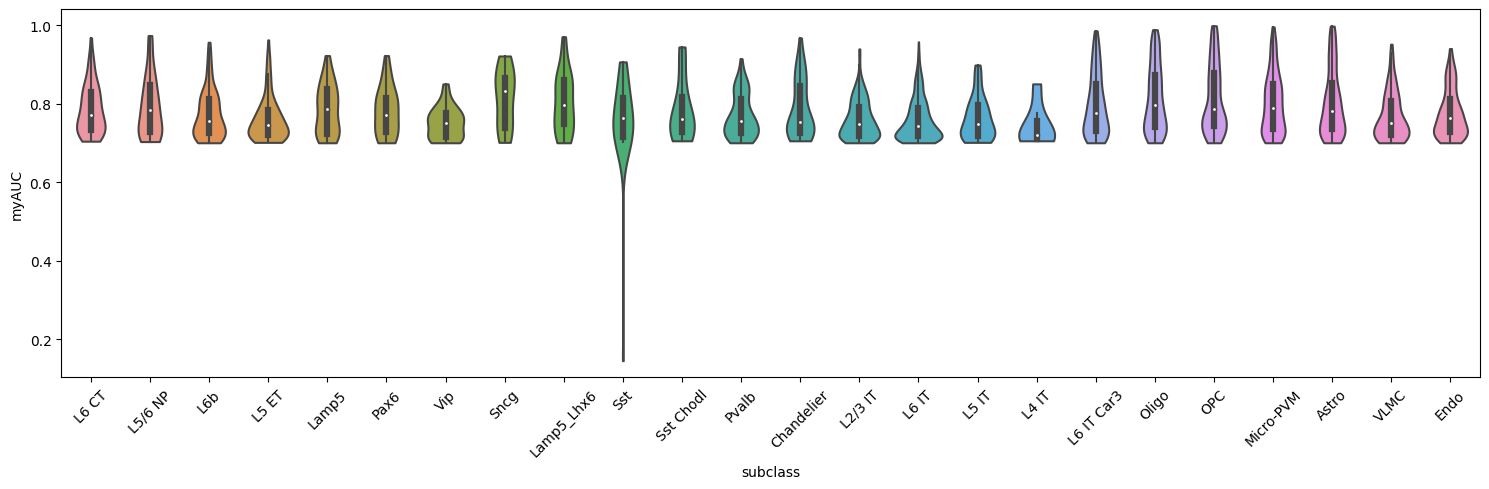

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_df, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [64]:
# reduce to marker genes above median
marker_medians = marker_genes_df.groupby('cluster').median()
marker_genes_reduced = None
for cluster in marker_genes_df['cluster'].unique():
    thresh = marker_medians.loc[cluster]['myAUC']
    gene_filter = marker_genes_df[(marker_genes_df['cluster']==cluster) & (marker_genes_df['myAUC']>thresh)]
    if marker_genes_reduced is None:
        marker_genes_reduced = gene_filter
    else:
        marker_genes_reduced = marker_genes_reduced.append(gene_filter)
        
gene_list = marker_genes_reduced['gene'].tolist()

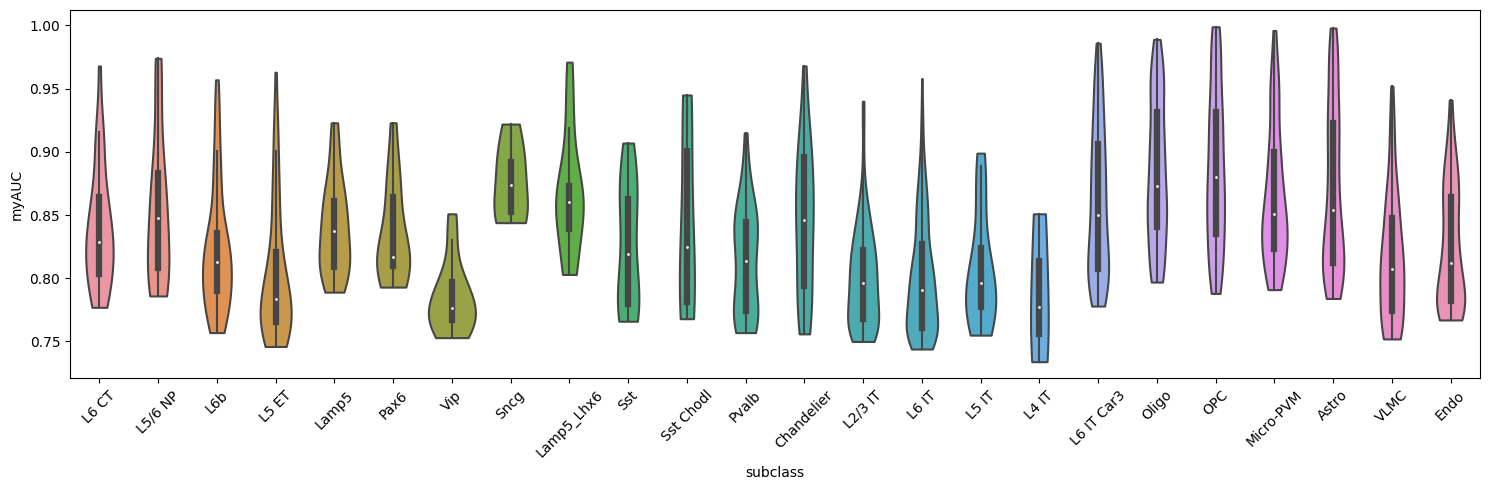

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_reduced, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [67]:
tg_map.set_training_genes(gene_list, meta={'training_genes': 'subclass RNAseq markers above median ROC'})
Audio(tada, autoplay=True)

starting with 1809 training genes..


In [68]:
# run mapping with default settings:
# device='cpu', mode='clusters', cluster_label='subclass'

tg_map.mapping()
Audio(tada, autoplay=True)

Score: 0.176, KL reg: 0.272
Score: 0.260, KL reg: 0.001
Score: 0.263, KL reg: 0.001
Score: 0.264, KL reg: 0.001
Score: 0.265, KL reg: 0.001
Score: 0.265, KL reg: 0.001
Score: 0.265, KL reg: 0.001
Score: 0.265, KL reg: 0.001
Score: 0.265, KL reg: 0.001
Score: 0.265, KL reg: 0.001


In [69]:
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'stereoseq',
 'spot_size': 'bin50',
 'spatial_region': 'MTG',
 'training_genes': 'subclass RNAseq markers above median ROC',
 'mode': 'clusters',
 'cluster_label': 'subclass'}

In [70]:
tg_map.save_mapping(save_path=data_path + 'NHP_spatial/mapping')
Audio(tada, autoplay=True)

analysis UID: 1664576157.125


In [7]:
tg_map = TangramMapping.load_from_timestamp(directory=data_path + 'NHP_spatial/mapping', timestamp='1664557614.734', file_name='evaluation')
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spot_size': 'bin100',
 'training_genes': 'subclass RNAseq markers above median ROC',
 'mode': 'clusters',
 'cluster_label': 'subclass',
 'spatial_method': 'stereoseq',
 'spatial_region': 'MTG',
 'species': 'macaque'}

In [8]:
tg_map.ad_sp.obs

x        y  uniform_density  rna_count_based_density
bin:3615_3786     3615.0   3786.0         0.000041             1.037277e-08
bin:3615_3986     3615.0   3986.0         0.000041             1.037277e-08
bin:3615_4086     3615.0   4086.0         0.000041             2.074553e-08
bin:3615_4186     3615.0   4186.0         0.000041             3.111830e-08
bin:3615_4286     3615.0   4286.0         0.000041             3.111830e-08
...                  ...      ...              ...                      ...
bin:23815_8786   23815.0   8786.0         0.000041             1.037277e-08
bin:23815_10486  23815.0  10486.0         0.000041             3.111830e-08
bin:23815_10886  23815.0  10886.0         0.000041             2.074553e-08
bin:23815_11086  23815.0  11086.0         0.000041             1.037277e-08
bin:23815_11186  23815.0  11186.0         0.000041             4.149106e-08

[24633 rows x 4 columns]

Running core analysis set..
1) plot training scores of mapping
2) plot mapping probability at each spatial position for each cluster label


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


3) get and plot the maximum cluster label for each spatial position
4) predict spatial gene expression, plot canonical markers and histogram of scores
           score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
mog     0.729875         True     0.511103     0.914507      -0.403404
opalin  0.633758         True     0.688710     0.939011      -0.250301
cux2    0.581788         True     0.778468     0.524233       0.254235
lamp5   0.548977         True     0.810945     0.865741      -0.054796
grik1   0.538399         True     0.733934     0.335638       0.398296
gfap    0.510817        False     0.218812     0.973044      -0.754231
rorb    0.495379         True     0.880364     0.620701       0.259663
pvalb   0.429364        False     0.842772     0.937685      -0.094913
fezf2   0.413252         True     0.913328     0.925061      -0.011733
lhx6    0.374108         True     0.912840     0.785012       0.127828


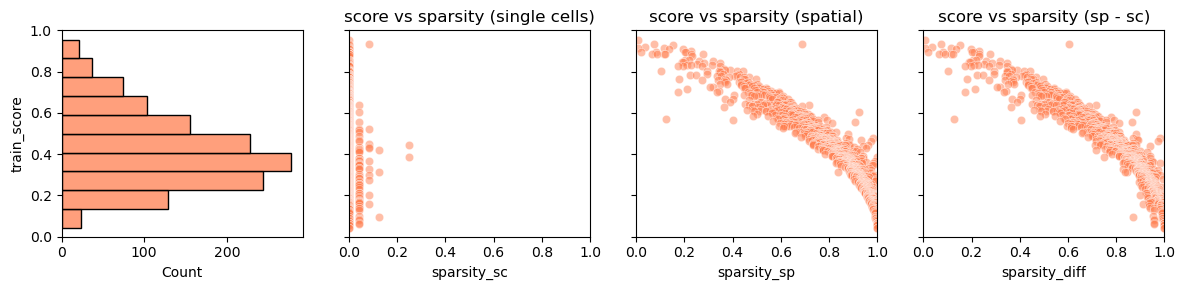

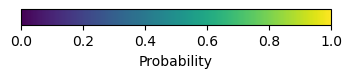

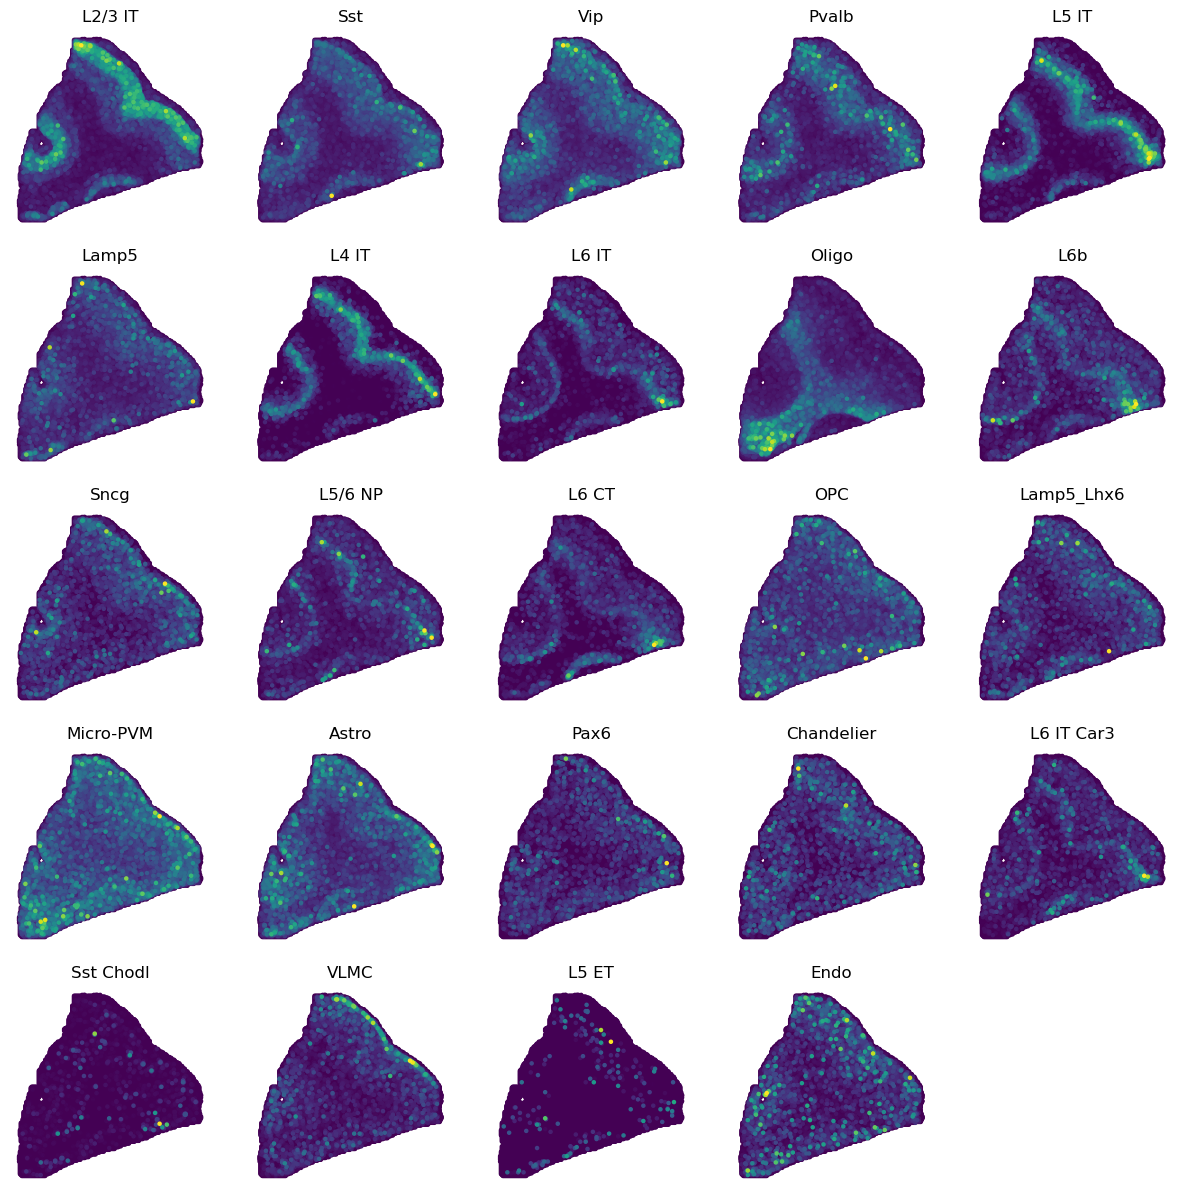

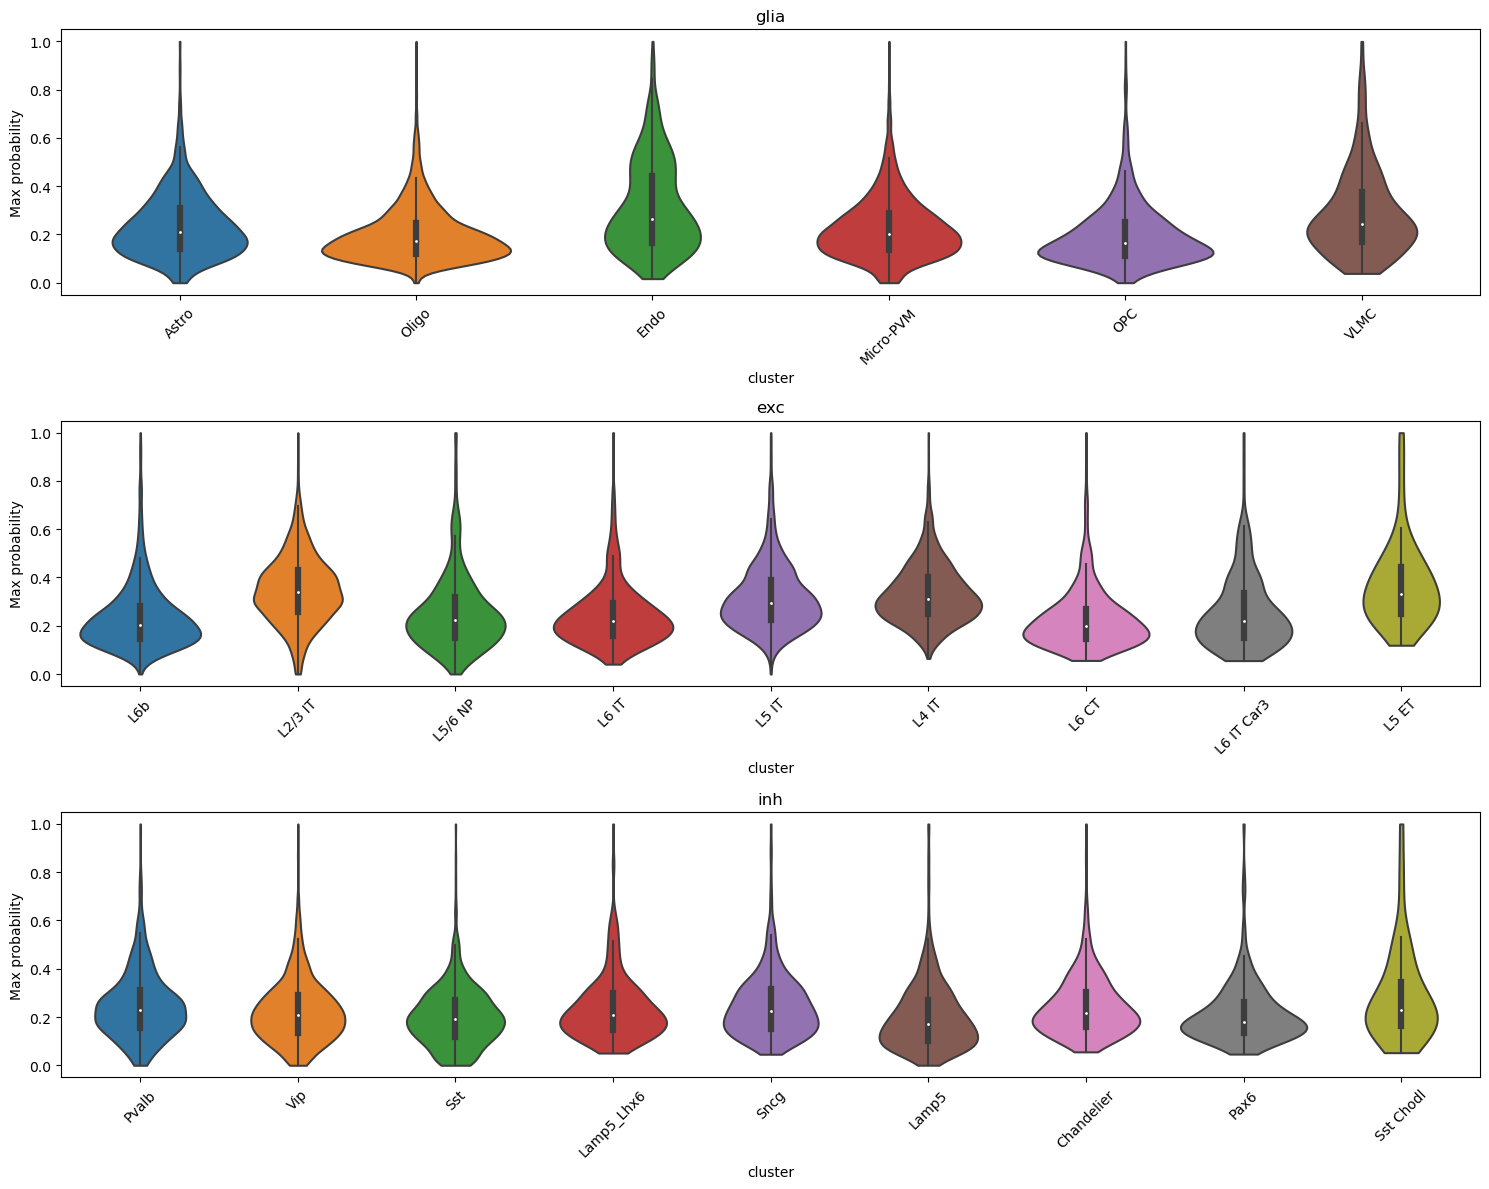

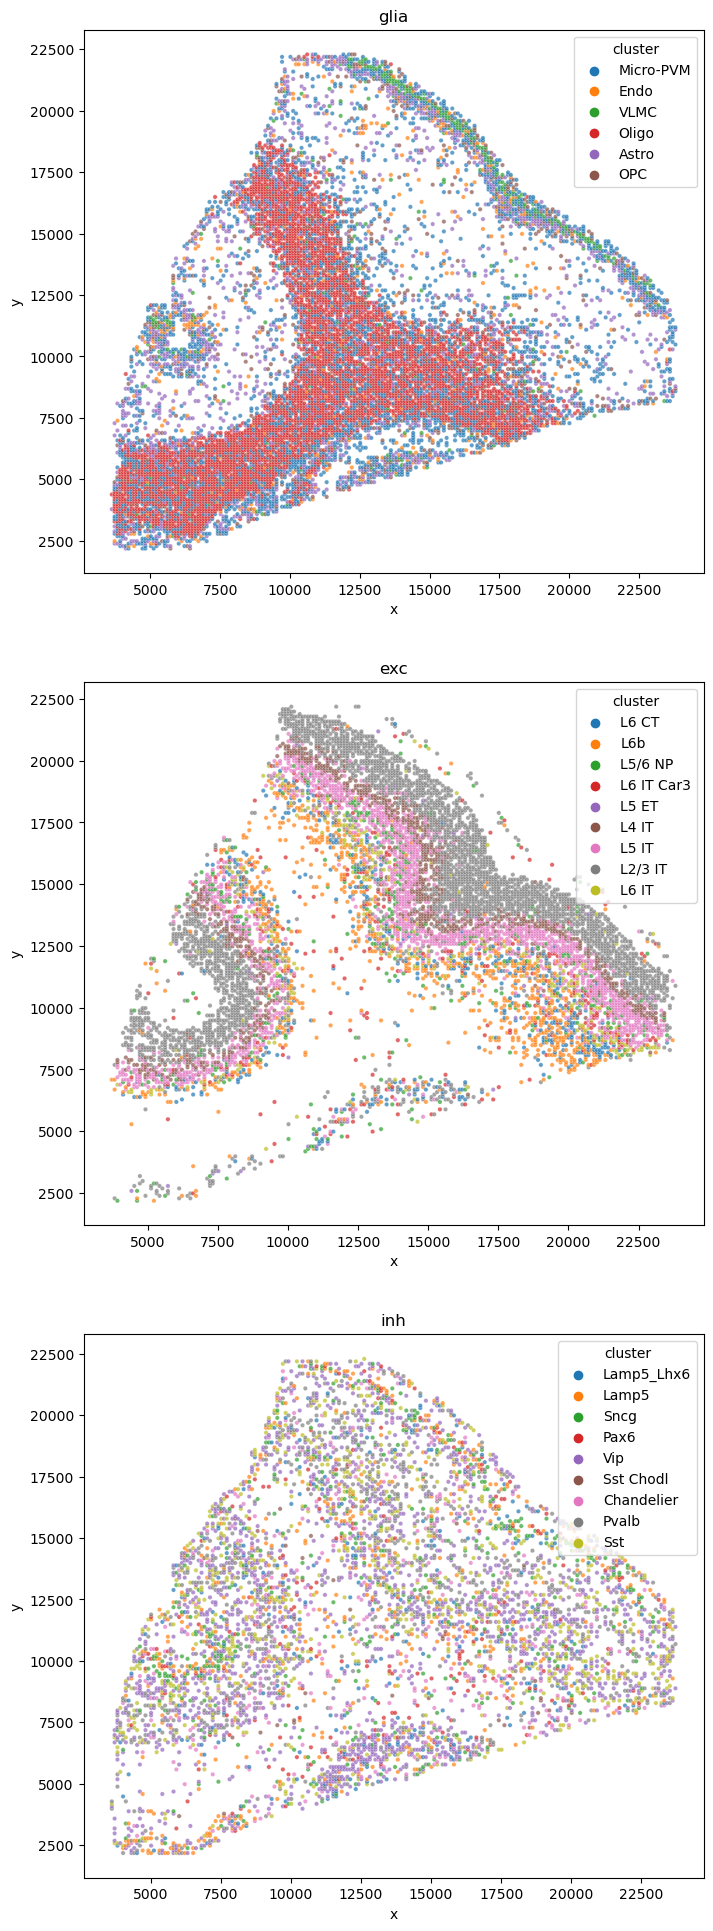

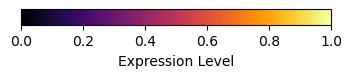

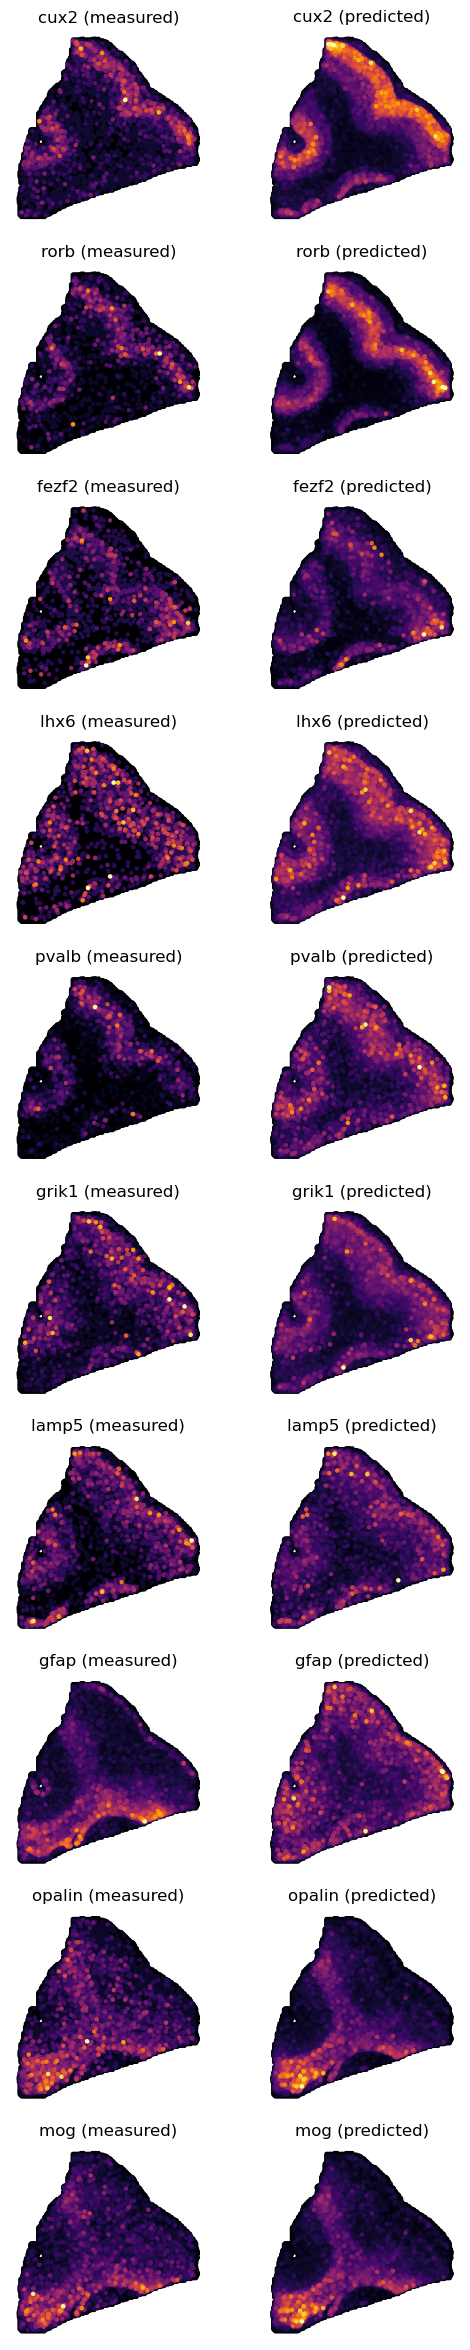

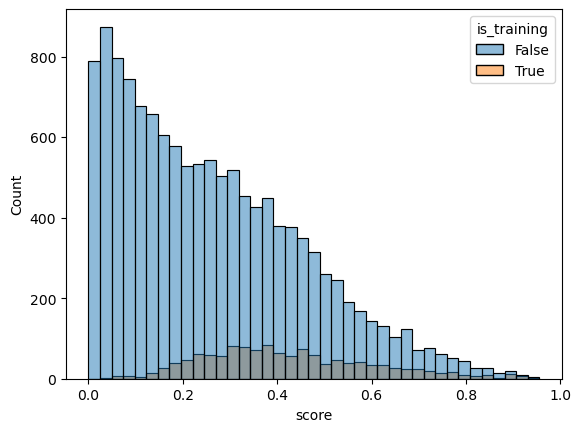

In [9]:
tg_map.evaluate_mapping()

<Figure size 640x480 with 0 Axes>

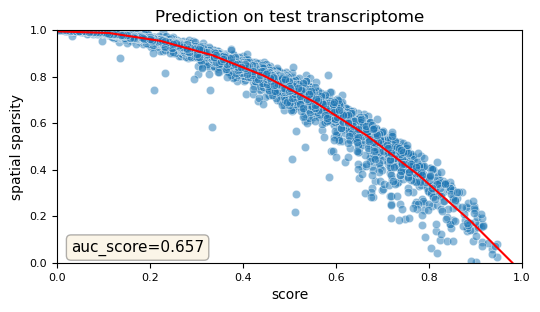

In [10]:
tangram.plot_auc(tg_map.spatial_score)

In [72]:
tg_map.save_mapping(save_path=data_path + 'NHP_spatial/mapping', file_name='evaluation', replace=True,)             
Audio(tada, autoplay=True)

analysis UID: 1664576157.125


(0.0, 1.0)

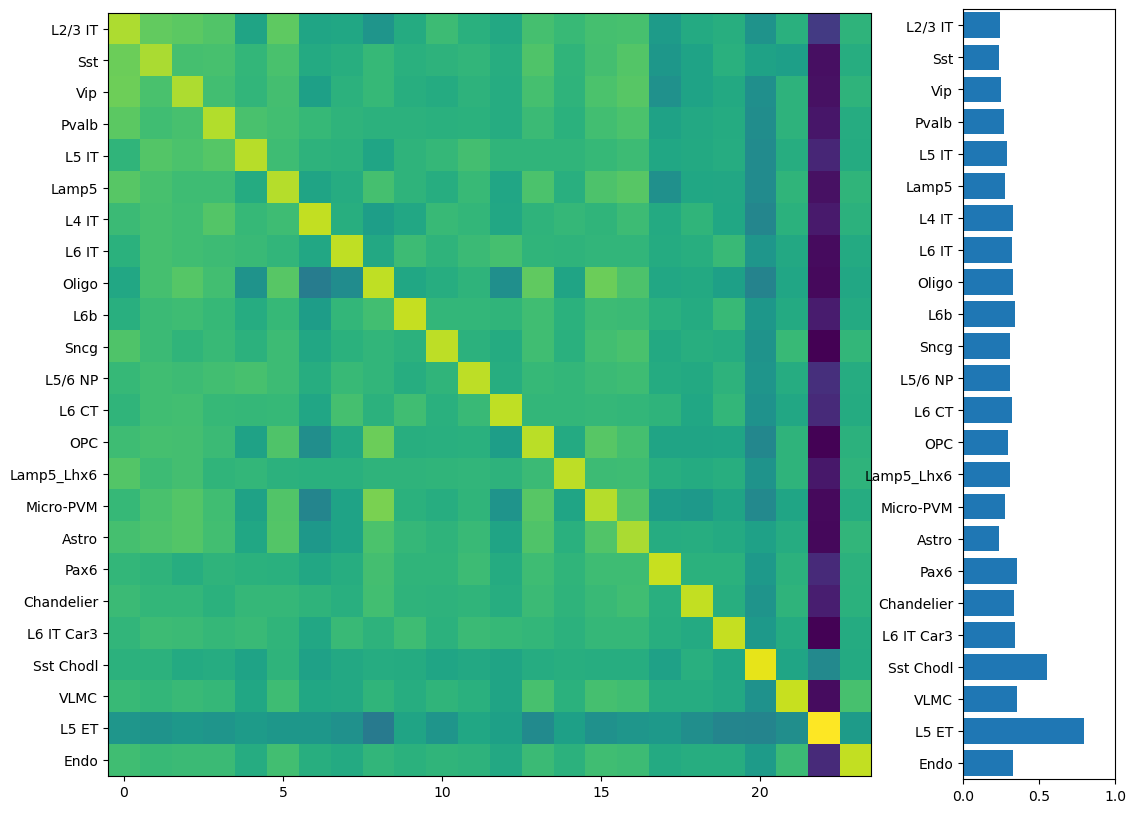

In [13]:
n_types = tg_map.ad_map.X.shape[0]
most_likely_type = tg_map.ad_map.X.argmax(axis=0)

conf_matrix = [[] for i in range(n_types)]
for i in range(tg_map.ad_map.X.shape[1]):
    conf_matrix[most_likely_type[i]].append(tg_map.ad_map.X[:, i])
for i in range(n_types):
    conf_matrix[i] = np.stack(conf_matrix[i], axis=1).sum(axis=1)
    conf_matrix[i] /= conf_matrix[i].sum()
conf_matrix = np.array(conf_matrix)

diff = np.diag(conf_matrix) / conf_matrix.sum(axis=1)



import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, 10))

gs = plt.GridSpec(1, 2, width_ratios=[5,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharey=ax1)

# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(np.log(conf_matrix))
ax1.set_yticks(np.arange(n_types))
ax1.set_yticklabels(tg_map.ad_map.obs['subclass']);

ax2.barh(np.arange(n_types), diff)
ax2.set_yticks(np.arange(n_types))
ax2.set_yticklabels(tg_map.ad_map.obs['subclass']);
ax2.set_xlim(0, 1)

